In [84]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Input, GRU, Dense
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError

In [68]:
# Set Parameters
SEQ_LEN = 60
EPOCHS = 100
BATCH_SIZE = 32
VAL_RATIO = 0.2

ticker = "TSLA"
features = ["Close"]
CLOSE_IDX = features.index("Close")

In [69]:
# Define Sequence Creation Function
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, CLOSE_IDX])
    return np.array(X), np.array(y)

In [70]:
# Load preprocessed data
df = pd.read_csv(f"../data/processed/tsla_processed.csv", parse_dates=["Date"], index_col="Date")
df = df.sort_values("Date")

# Extract selected features
data = df[features].values

# Split into train+val and test sets
total_len = len(data)
test_start_idx = int(total_len * 0.8)
train_val_data = data[:test_start_idx]
test_data = data[test_start_idx - SEQ_LEN:]

In [71]:
# Split train_val into train and validation
train_size = int(len(train_val_data) * (1 - VAL_RATIO))
train_data = train_val_data[:train_size]
val_data = train_val_data[train_size - SEQ_LEN:]

In [72]:
# Scale the Data
scaler = MinMaxScaler()
scaler.fit(train_data)

train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [73]:
# Create Sequences for GRU
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_val, y_val = create_sequences(val_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

X_train = X_train.reshape((X_train.shape[0], SEQ_LEN, len(features)))
X_val = X_val.reshape((X_val.shape[0], SEQ_LEN, len(features)))
X_test = X_test.reshape((X_test.shape[0], SEQ_LEN, len(features)))

In [74]:
# Build the GRU Model
model = Sequential([
    Input(shape=(SEQ_LEN, len(features))),
    GRU(128, return_sequences=True),
    GRU(64, return_sequences=False),
    Dense(1)
])

model.compile(optimizer="adam", loss=MeanSquaredError())
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [75]:
# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0561 - val_loss: 0.0052
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0034 - val_loss: 8.9176e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0013 - val_loss: 6.5167e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0011 - val_loss: 6.2774e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0010 - val_loss: 5.7916e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 9.6040e-04 - val_loss: 5.8214e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 9.7008e-04 - val_loss: 5.2536e-04
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 7.7637e-04 - val_loss: 6.7271e-04
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 9.2917e-04 - val_loss: 4.8539e-04
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 8.3019e-04 - val_loss: 4.7287e-04
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 6.9733e-04 - val_loss: 4.6571e-04


In [80]:
# Find the best validation loss (minimum value) and its epoch
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss)
best_train_loss = history.history['loss'][best_epoch]

print("Best Epoch:", best_epoch)
print("Best Validation Loss:", best_val_loss)
print("Corresponding Training Loss:", best_train_loss)

Best Epoch: 70
Best Validation Loss: 0.00033070973586291075
Corresponding Training Loss: 0.000572497840039432


In [76]:
# Make Predictions and Inverse Scale
y_pred_scaled = model.predict(X_test)

# Inverse transform only the 'Close' column
temp_array = np.zeros((len(y_pred_scaled), len(features)))
temp_array[:, CLOSE_IDX] = y_pred_scaled.flatten()
y_pred = scaler.inverse_transform(temp_array)[:, CLOSE_IDX]

temp_array_true = np.zeros((len(y_test), len(features)))
temp_array_true[:, CLOSE_IDX] = y_test
y_true = scaler.inverse_transform(temp_array_true)[:, CLOSE_IDX]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


In [82]:
# Evaluate the Model
test_mae = mean_absolute_error(y_true, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
test_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
test_r2 = r2_score(y_true, y_pred)

print(f"Model evaluation for {ticker} on the test set:")
print(f"  MAE:  {test_mae:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  MAPE: {test_mape:.2f}%")
print(f"  R^2:  {test_r2:.4f}")

Model evaluation for TSLA on the test set:
  MAE:  9.06
  RMSE: 12.65
  MAPE: 3.25%
  R^2:  0.9736


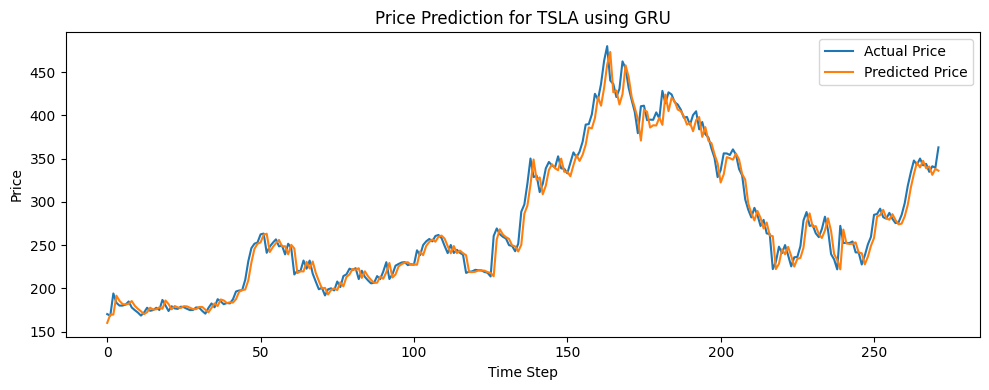

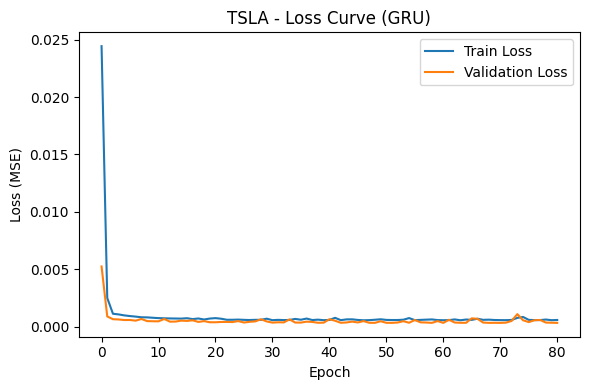

In [78]:
# Plot Predictions and Loss Curve
plt.figure(figsize=(10, 4))
plt.plot(y_true, label="Actual Price")
plt.plot(y_pred, label="Predicted Price")
plt.title(f"Price Prediction for {ticker} using GRU")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title(f"{ticker} - Loss Curve (GRU)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.tight_layout()
plt.show()

In [87]:
# Save the trained model and the fitted scaler for later use
model.save(f"../model/model.keras")
joblib.dump(scaler, f"../model/scaler.pkl")

['../model/scaler.pkl']

In [88]:
# Build a dictionary with complete model details
model_info = {
    "ticker": ticker,
    "features": features,
    "sequence_length": SEQ_LEN,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "validation_ratio": VAL_RATIO,
    "model_architecture": [
        {"layer": "Input", "shape": [SEQ_LEN, len(features)]},
        {"layer": "GRU", "units": 128, "return_sequences": True},
        {"layer": "GRU", "units": 64, "return_sequences": False},
        {"layer": "Dense", "units": 1}
    ],
    "loss_function": "MeanSquaredError",
    "optimizer": "adam",
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 10,
        "restore_best_weights": True
    },
    "training_history": {
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
        "corresponding_train_loss": best_train_loss,
        "note": "These values correspond to the best model checkpoint restored by early stopping."
    },
    "evaluation_metrics": {
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_mape": test_mape,
        "test_r2": test_r2
    },
    "data_paths": {
        "processed_data": "../data/processed/tsla_processed.csv"
    },
    "scaler": "MinMaxScaler",
    "notes": "Train/Val split was based on 80/20 of training data. Test set is the last 20% of the original dataset."
}

# Save model information to a JSON file
with open("../model/info.json", "w") as f:
    json.dump(model_info, f, indent=2)